In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

## Importing Data and DateTime index preparation

In [48]:
df = pd.read_csv("data/bicikelj_train.csv")
df = df.set_index("timestamp")
df.index = pd.to_datetime(df.index)

# Round the index to the nearest 5 minuter interval ignoring seconds
df.index = df.index.round("5min")
# Where there are duplicate indexes subtract 5 minutes from the first instance
df.index = df.index.where(~df.index.duplicated(keep="first"), df.index - pd.Timedelta(minutes=5))

# Count the number of duplicate index values
display(df.index.duplicated().sum())

display(df.head())
display(df.info())

36

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,POGAČARJEV TRG-TRŽNICA,KONGRESNI TRG-ŠUBIČEVA ULICA,CANKARJEVA UL.-NAMA,BREG,GRUDNOVO NABREŽJE-KARLOVŠKA C.,MIKLOŠIČEV PARK,BAVARSKI DVOR,TRG OF-KOLODVORSKA UL.,MASARYKOVA DDC,...,POVŠETOVA - KAJUHOVA,SOSESKA NOVO BRDO,TEHNOLOŠKI PARK,VOJKOVA - GASILSKA BRIGADA,GERBIČEVA - ŠPORTNI PARK SVOBODA,DOLENJSKA C. - STRELIŠČE,ROŠKA - STRELIŠKA,LEK - VEROVŠKOVA,VOKA - SLOVENČEVA,SUPERNOVA LJUBLJANA - RUDNIK
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-08-02 13:05:00,17,17,20,26,10,10,16,7,12,2,...,9,7,5,4,2,9,4,8,3,1
2022-08-02 13:10:00,18,17,19,25,10,11,15,7,12,4,...,9,7,5,4,1,9,4,8,2,1
2022-08-02 13:15:00,17,18,19,25,9,11,16,7,12,5,...,9,7,5,4,1,9,4,8,2,1
2022-08-02 13:20:00,18,15,20,26,12,11,18,6,13,1,...,9,7,5,2,1,9,4,8,2,1
2022-08-02 13:25:00,20,16,19,23,12,10,17,6,15,1,...,9,7,5,2,1,9,4,8,2,1


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7739 entries, 2022-08-02 13:05:00 to 2022-10-01 18:25:00
Data columns (total 83 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE    7739 non-null   int64
 1   POGAČARJEV TRG-TRŽNICA                7739 non-null   int64
 2   KONGRESNI TRG-ŠUBIČEVA ULICA          7739 non-null   int64
 3   CANKARJEVA UL.-NAMA                   7739 non-null   int64
 4   BREG                                  7739 non-null   int64
 5   GRUDNOVO NABREŽJE-KARLOVŠKA C.        7739 non-null   int64
 6   MIKLOŠIČEV PARK                       7739 non-null   int64
 7   BAVARSKI DVOR                         7739 non-null   int64
 8   TRG OF-KOLODVORSKA UL.                7739 non-null   int64
 9   MASARYKOVA DDC                        7739 non-null   int64
 10  VILHARJEVA CESTA                      7739 non-null   int64
 11  PARK NA

None

## Creating a DataFrame for each station

In [49]:
# Split the dataframe into multiple dataframes, each with one station
df_list = [df[[station]] for station in df.columns]
df_list[0].head()

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE
timestamp,
2022-08-02 13:05:00,17
2022-08-02 13:10:00,18
2022-08-02 13:15:00,17
2022-08-02 13:20:00,18
2022-08-02 13:25:00,20


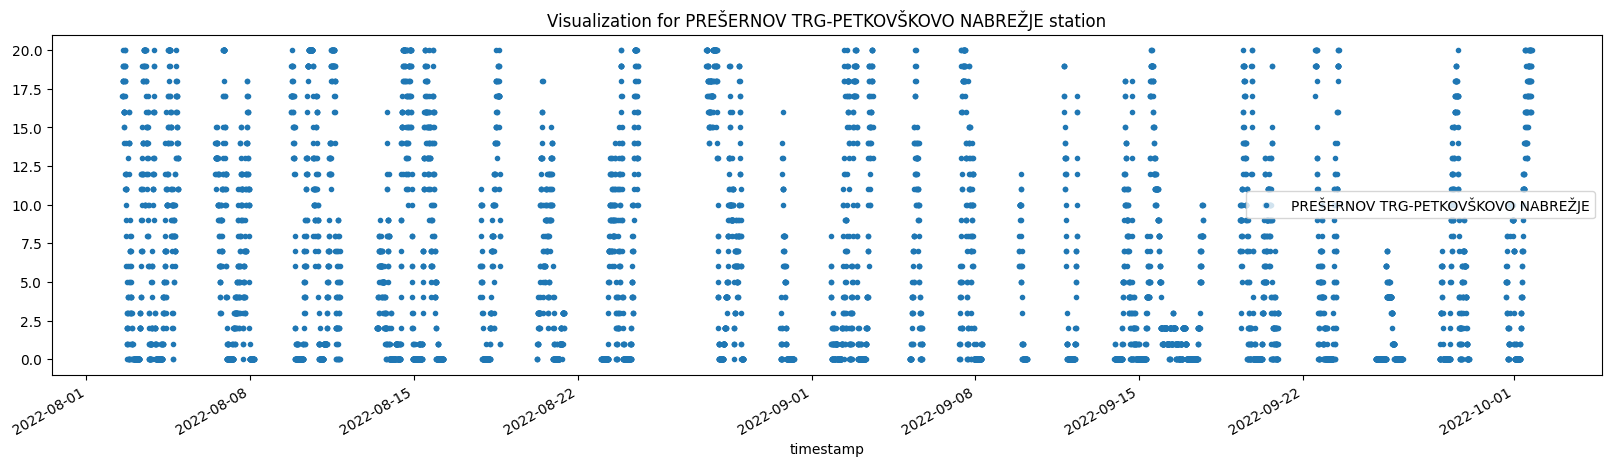

In [50]:
ig, ax = plt.subplots(figsize=(20, 5))
df_list[0].plot(ax=ax, label='Training Set', title=f"Visualization for {df_list[0].columns[0]} station", style=".")
plt.show()

## Time Series Cross Validation Example and Visualization

In [51]:
tss = TimeSeriesSplit(n_splits=10, gap=(60 // 5))
df_list = [station.sort_index() for station in df_list]

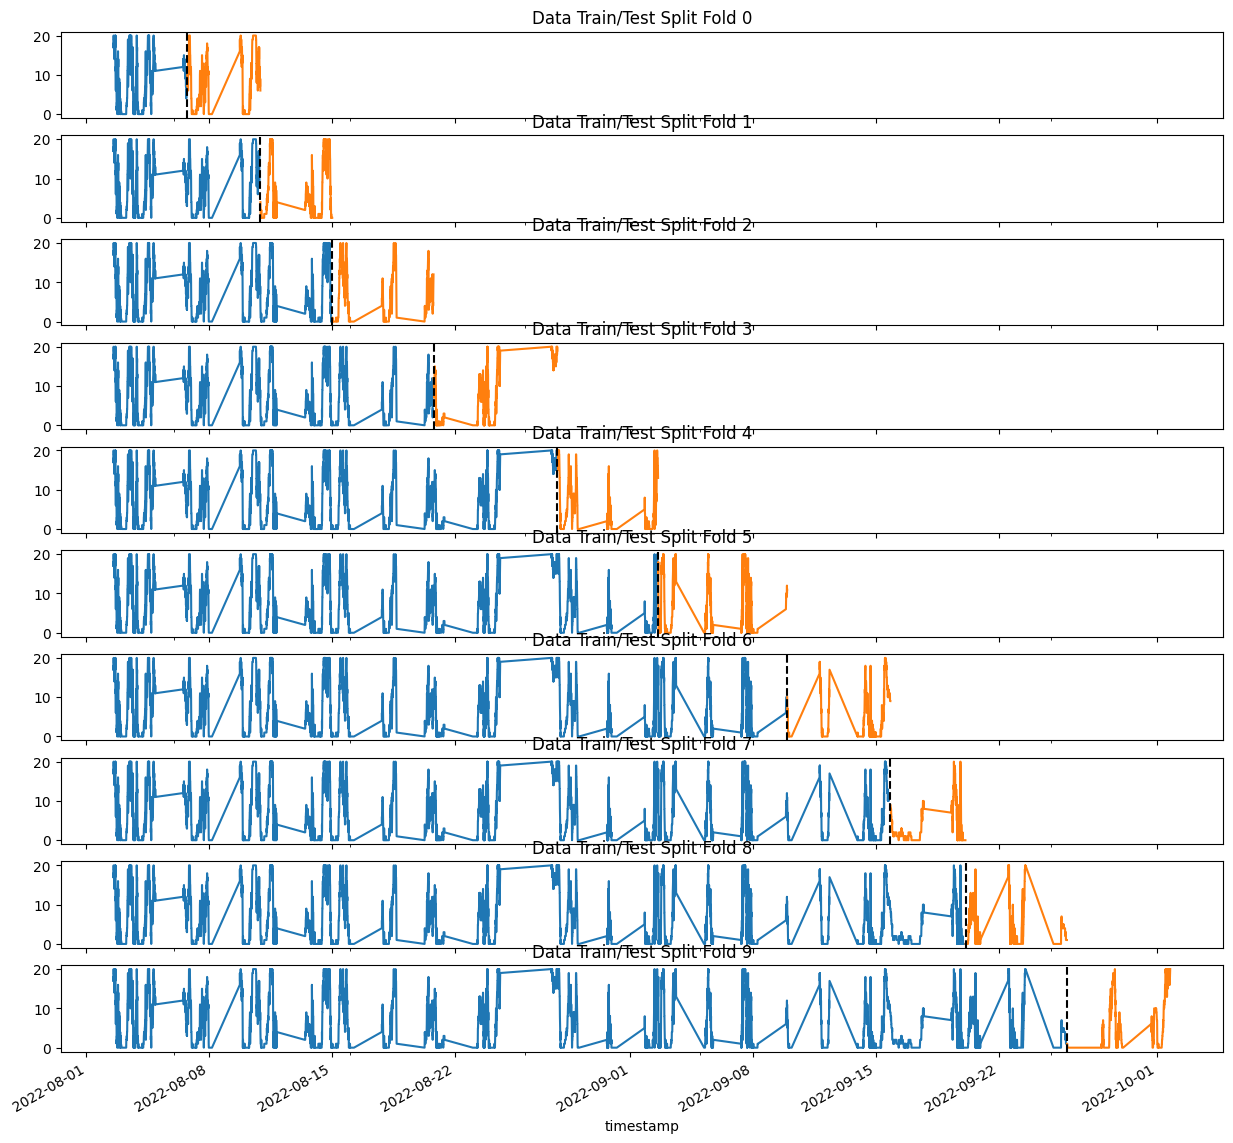

In [52]:
fig, axs = plt.subplots(10, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_list[0]):
    train = df_list[0].iloc[train_idx]
    test = df_list[0].iloc[val_idx]
    train[df_list[0].columns[0]].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test[df_list[0].columns[0]].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Feature creation

In [53]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

df_list = [create_features(station) for station in df_list]
df_list[0].head()

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth
timestamp,,,,,,
2022-08-02 13:05:00,17,13,1,8,214,2
2022-08-02 13:10:00,18,13,1,8,214,2
2022-08-02 13:15:00,17,13,1,8,214,2
2022-08-02 13:20:00,18,13,1,8,214,2
2022-08-02 13:25:00,20,13,1,8,214,2


In [54]:
def add_lags(df):
    df = df.copy()
    target_map = df[df.columns[0]].to_dict()

    # Create a lag feature by getting the value of the target variable 60 minutes before
    df['lag1'] = (df.index - pd.Timedelta('60 minutes')).map(target_map)
    # Fill in missing values with the value of the next of previous feature
    df["lag1"] = df["lag1"].fillna(df["lag1"].shift(1)).fillna(df["lag1"].shift(-1))
    # If there are still missing values fill them with the mean value of 6 surrounding values
    df["lag1"] = df["lag1"].fillna(df["lag1"].rolling(7, min_periods=1, center=True).mean()).round(0).astype("Int64") #.median() ?
    df["lag1"] = df["lag1"].fillna(df["lag1"].shift(1)).fillna(df["lag1"].shift(-1))
    # The same process for 90 minutes nad 120 minutes
    df['lag2'] = (df.index - pd.Timedelta('90 minutes')).map(target_map)
    df["lag2"] = df["lag2"].fillna(df["lag2"].shift(1)).fillna(df["lag2"].shift(-1))
    df["lag2"] = df["lag2"].fillna(df["lag2"].rolling(7, min_periods=1, center=True).mean()).round(0).astype("Int64")
    df["lag2"] = df["lag2"].fillna(df["lag2"].shift(1)).fillna(df["lag2"].shift(-1))
    df['lag3'] = (df.index - pd.Timedelta('120 minutes')).map(target_map)
    df["lag3"] = df["lag3"].fillna(df["lag3"].shift(1)).fillna(df["lag3"].shift(-1))
    df["lag3"] = df["lag3"].fillna(df["lag3"].rolling(7, min_periods=1, center=True).mean()).round(0).astype("Int64")
    df["lag3"] = df["lag3"].fillna(df["lag3"].shift(1)).fillna(df["lag3"].shift(-1))

    return df

df_list = [add_lags(station) for station in df_list]
display(df_list[0].tail())
display(df_list[0].isna().sum())

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,lag1,lag2,lag3
timestamp,,,,,,,,,
2022-10-01 18:00:00,20,18,5,10,274,1,20,16,19
2022-10-01 18:05:00,18,18,5,10,274,1,20,16,19
2022-10-01 18:10:00,19,18,5,10,274,1,20,17,19
2022-10-01 18:15:00,19,18,5,10,274,1,20,17,18
2022-10-01 18:25:00,20,18,5,10,274,1,20,18,18


PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE      0
hour                                    0
dayofweek                               0
month                                   0
dayofyear                               0
dayofmonth                              0
lag1                                   40
lag2                                  152
lag3                                  262
dtype: int64

## Model Testing With Cross Validation

In [55]:
tss = TimeSeriesSplit(n_splits=10, gap=(60 // 5))
df_list = [station.sort_index() for station in df_list]
scores_list = []
preds_list = []
for station in df_list:
        fold = 0
        preds = []
        scores = []
        for train_idx, val_idx in tss.split(station):
                train = station.iloc[train_idx]
                test = station.iloc[val_idx]

                train = create_features(train)
                test = create_features(test)

                FEATURES = ['hour', 'dayofweek', 'month', 'dayofyear', 'dayofmonth',
                                'lag1','lag2','lag3']
                TARGET = station.columns[0]

                X_train = train[FEATURES]
                y_train = train[TARGET]

                X_test = test[FEATURES]
                y_test = test[TARGET]

                reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                                        n_estimators=1000,
                                        early_stopping_rounds=50,
                                        objective='reg:absoluteerror',
                                        max_depth=3,
                                        learning_rate=0.1)
                
                reg.fit(X_train, y_train,
                        eval_set=[(X_train, y_train), (X_test, y_test)],
                        verbose=False)

                y_pred = reg.predict(X_test)
                preds.append(y_pred)
                score = mean_absolute_error(y_test, y_pred)
                scores.append(score)
        
        preds_list.append(preds)
        scores_list.append(scores)

        print(f'{station.columns[0]}: Score across folds {np.mean(scores):0.4f}')
        print(f'{station.columns[0]}: Fold scores:{scores}')

PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE: Score across folds 4.3360
PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE: Fold scores:[5.741055250247333, 5.031132603537127, 4.7117616228069075, 5.255654782694692, 3.7714500199467844, 5.523112938489472, 3.3266567015673036, 2.4181832908467253, 2.911540281936357, 4.668989556261629]
POGAČARJEV TRG-TRŽNICA: Score across folds 4.9383
POGAČARJEV TRG-TRŽNICA: Fold scores:[4.5268142457937515, 5.298788575753623, 4.351687922969111, 4.350094316249043, 4.735243310017186, 4.500858972111391, 4.359633235703984, 9.667965723964707, 3.4957274188649223, 4.096678488369856]
KONGRESNI TRG-ŠUBIČEVA ULICA: Score across folds 3.9573
KONGRESNI TRG-ŠUBIČEVA ULICA: Fold scores:[5.458750698324637, 3.267873222389885, 2.810805234406276, 4.222637624622576, 4.629764446696422, 4.6764508120445365, 3.585368755955784, 2.4208604236349336, 4.102405305146365, 4.39811385338457]
CANKARJEVA UL.-NAMA: Score across folds 5.9654
CANKARJEVA UL.-NAMA: Fold scores:[8.40467779078901, 6.614838106294758, 5.875415

In [41]:
# Print the average score across all stations
print(f'Average Score: {np.mean(scores_list):0.4f}')

Average Score: 2.1325


## Training the model on the whole dataset (One for each station)

In [42]:
models = []
for station in df_list:
        FEATURES = ['hour', 'dayofweek', 'month', 'dayofyear', 'dayofmonth',
                        'lag1','lag2','lag3']
        TARGET = station.columns[0]
        
        X_all = station[FEATURES]
        y_all = station[TARGET]
        
        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                                   n_estimators=1000,
                                   early_stopping_rounds=50,
                                   objective='reg:absoluteerror',
                                   max_depth=3,
                                   learning_rate=0.1)
        reg.fit(X_all, y_all,
                eval_set=[(X_all, y_all)],
                verbose=False)
        
        models.append(reg)


## Preparing the test data for prediction

In [43]:
df_test = pd.read_csv("data/bicikelj_test.csv")
df_test = df_test.set_index("timestamp")
df_test.index = pd.to_datetime(df_test.index)

# Create a list of dataframes, one for each station for the test and train set
df_train_list = [df[[station]] for station in df.columns]
df_test_list = [df_test[[station]] for station in df_test.columns]

# Add the "Test" column to the dataframes
df_train_list = [station.assign(Test=False) for station in df_train_list]
df_test_list = [station.assign(Test=True) for station in df_test_list]

test_df_list = []
for train, test in zip(df_train_list, df_test_list):
        # Concatenate the two dataframes
        train_n_test = pd.concat([train, test], axis=0)
        train_n_test = train_n_test.sort_index()
        # Add the lags and datetime features
        train_n_test = create_features(train_n_test)
        train_n_test = add_lags(train_n_test)
        # Select only the rows which are in the test set
        station_test = train_n_test[train_n_test["Test"] == True]
        # Drop the "Test" column
        station_test = station_test.drop("Test", axis=1)
        # Add the dataframe to the list
        test_df_list.append(station_test)

display(test_df_list[0].head())
display(test_df_list[0].isna().sum())

,PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE,hour,dayofweek,month,dayofyear,dayofmonth,lag1,lag2,lag3
timestamp,,,,,,,,,
2022-08-04 23:24:00,NaN,23,3,8,216,4,14,17,16
2022-08-05 00:24:00,NaN,0,4,8,217,5,14,17,16
2022-08-08 04:58:00,NaN,4,0,8,220,8,0,0,0
2022-08-08 05:58:00,NaN,5,0,8,220,8,0,0,0
2022-08-11 21:13:00,NaN,21,3,8,223,11,4,2,9


PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE    40
hour                                   0
dayofweek                              0
month                                  0
dayofyear                              0
dayofmonth                             0
lag1                                   0
lag2                                   0
lag3                                   0
dtype: int64

## Predicting the test data

In [45]:
preds_list = []
for station in test_df_list:
    # Get the predictions for the station
    pred = reg.predict(station[FEATURES])
    # Transform the predictions to integers
    pred = pred.round(0).astype(np.int64)
    # Add the predictions to the list
    preds_list.append(pred)

In [46]:
# Add the predictions to the test set
predicted = pd.read_csv("data/bicikelj_test.csv")
stations = predicted.columns[1:]
for station, pred in zip(stations, preds_list):
        predicted[station] = pred

predicted.to_csv("data/predicted.csv", index=False)